<a href="https://colab.research.google.com/github/hothai19o5/last_dance_train_model/blob/main/Detect_Irregular_Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DETECT IRREGULAR HEARTBEAT**

---



## **Tải dữ liệu**

Đọc dữ liệu từ file `/content/human_vital_signs_dataset_2024.csv` vào DataFrame.


In [24]:
import pandas as pd

df = pd.read_csv('/content/human_vital_signs_dataset_2024.csv')
print("\n--- 5 dòng dữ liệu mẫu ---\n")
display(df.head())
print("\n\n--- Thông tin tổng quan về DataFrame ---\n")
df.info()


--- 5 dòng dữ liệu mẫu ---



,Patient ID,Heart Rate,Respiratory Rate,Timestamp,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,1,60,12,2024-07-19 21:53:45.729841,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,0.121033,38,32.459031,98.666667,High Risk
1,2,63,18,2024-07-19 21:52:45.729841,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,0.117062,42,12.771246,98.000000,High Risk
2,3,63,15,2024-07-19 21:51:45.729841,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,0.053200,53,28.821069,95.666667,Low Risk
3,4,99,16,2024-07-19 21:50:45.729841,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,0.064475,46,28.554611,87.333333,High Risk
4,5,69,16,2024-07-19 21:49:45.729841,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,0.118484,62,16.081438,96.666667,High Risk




--- Thông tin tổng quan về DataFrame ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Patient ID                200020 non-null  int64  
 1   Heart Rate                200020 non-null  int64  
 2   Respiratory Rate          200020 non-null  int64  
 3   Timestamp                 200020 non-null  object 
 4   Body Temperature          200020 non-null  float64
 5   Oxygen Saturation         200020 non-null  float64
 6   Systolic Blood Pressure   200020 non-null  int64  
 7   Diastolic Blood Pressure  200020 non-null  int64  
 8   Age                       200020 non-null  int64  
 9   Gender                    200020 non-null  object 
 10  Weight (kg)               200020 non-null  float64
 11  Height (m)                200020 non-null  float64
 12  Derived_HRV               200020 non-null  float64
 13  



------




## **Tương quan giữa các trường dữ liệu so với Risk Category**




Biến '**Risk Category**' là biến mục tiêu dạng phân loại (categorical). Để tính tương quan với các biến số khác, chúng ta cần mã hóa nó thành số. **Label Encoding** là phương pháp đơn giản nhất cho mục đích này.



In [15]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Khởi tạo đối tượng LabelEncoder
le = LabelEncoder()

# Mã hóa cột mục tiêu 'Risk Category'
# Tạo một cột mới để lưu trữ giá trị đã được mã hóa
df['Risk_Category_Encoded'] = le.fit_transform(df['Risk Category'])

# In ra ánh xạ để bạn biết các label được mã hóa thành số nào
print("Ánh xạ các hạng mục rủi ro:")
for i, category in enumerate(le.classes_):
    print(f"'{category}' đã được mã hóa thành: {i}")

Ánh xạ các hạng mục rủi ro:
'High Risk' đã được mã hóa thành: 0
'Low Risk' đã được mã hóa thành: 1


Mã hóa cả cột **Gender**

In [16]:
# Mã hóa cột 'Gender'
df['Gender_Encoded'] = le.fit_transform(df['Gender'])

Lọc các cột cần phân tích

Loại bỏ các cột không dùng cho phân tích tương quan:

- 'Patient ID': Là ID, không có ý nghĩa tương quan.

- 'Timestamp': Là chuỗi thời gian, cần xử lý đặc biệt (nếu muốn dùng), nhưng nên loại bỏ cho phân tích tương quan đơn giản.

- 'Risk Category' và 'Gender': Đã có bản mã hóa.

In [17]:
# Danh sách các cột để tính toán tương quan, bao gồm cả cột mục tiêu đã mã hóa
correlation_columns = [
    'Heart Rate', # Nhịp tim
    'Respiratory Rate', # Nhịp thở
    'Body Temperature', # Nhiệt độ cơ thể
    'Oxygen Saturation', # Nồng độ O2 trong máu
    'Systolic Blood Pressure', # Huyết áp tâm thu
    'Diastolic Blood Pressure', # Huyết áp tâm trương
    'Age', 'Weight (kg)', 'Height (m)',
    'Derived_HRV', # Chỉ số đo lường sự biến đổi thời gian giữa các nhịp tim.
    'Derived_Pulse_Pressure', # Sự chênh lệch giữa hai giá trị huyết áp trong chu kỳ tim.
    'Derived_BMI', # BMI
    'Derived_MAP', # Huyết áp trung bình trong một chu kỳ tim duy nhất.
    'Gender_Encoded', # Biến phân loại đã mã hóa
    'Risk_Category_Encoded' # Biến mục tiêu đã mã hóa
]

# Tạo DataFrame chỉ chứa các cột cần thiết
df_corr = df[correlation_columns]

# Tính Ma trận Tương quan
correlation_matrix = df_corr.corr(method='pearson')

### **Xem xét Tương quan với Biến Mục tiêu**

#### **Tính toán ma trận tương quan Pearson**



In [18]:
# Lọc ra các giá trị tương quan với biến mục tiêu
target_correlations = correlation_matrix['Risk_Category_Encoded'].sort_values(ascending=False)

# In kết quả
print("\n--- Tương quan của các Trường dữ liệu so với 'Risk Category' ---")
print(target_correlations)


--- Tương quan của các Trường dữ liệu so với 'Risk Category' ---
Risk_Category_Encoded       1.000000
Height (m)                  0.091435
Derived_Pulse_Pressure      0.004936
Systolic Blood Pressure     0.003534
Gender_Encoded              0.002528
Derived_HRV                 0.001522
Respiratory Rate            0.001312
Oxygen Saturation           0.000652
Derived_MAP                -0.000760
Body Temperature           -0.001181
Age                        -0.002466
Diastolic Blood Pressure   -0.003607
Weight (kg)                -0.024642
Derived_BMI                -0.151767
Heart Rate                 -0.368487
Name: Risk_Category_Encoded, dtype: float64


### **Trực quan hóa**

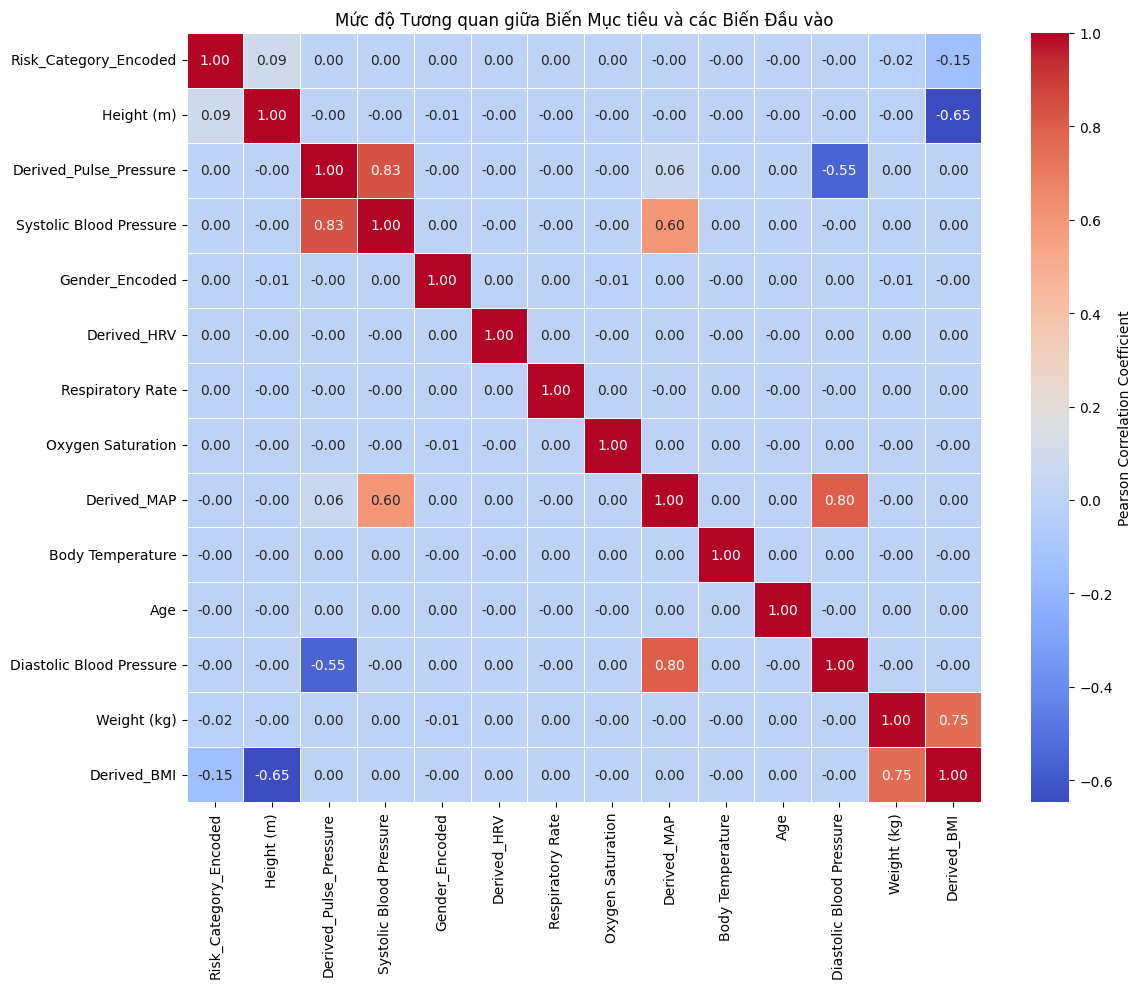

In [19]:
# Trực quan hóa tương quan
plt.figure(figsize=(12, 10))
# Lọc các tương quan của cột mục tiêu để vẽ biểu đồ Heatmap của chỉ riêng cột đó
# Ví dụ, lấy 10 cột có tương quan cao nhất và thấp nhất với cột mục tiêu
top_correlated_features = target_correlations[1:10].index.tolist() + target_correlations[-5:-1].index.tolist()
features_to_plot = ['Risk_Category_Encoded'] + top_correlated_features

# Tạo một DataFrame chứa chỉ các cột đó để vẽ mối tương quan giữa chúng
corr_subset = df[features_to_plot].corr()

sns.heatmap(corr_subset,
            annot=True, # Hiển thị giá trị tương quan
            cmap='coolwarm', # Chọn màu sắc
            fmt=".2f", # Định dạng số thập phân
            linewidths=.5, # Độ rộng của đường kẻ
            cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title("Mức độ Tương quan giữa Biến Mục tiêu và các Biến Đầu vào")
plt.tight_layout()
plt.savefig('correlation_heatmap_subset.png')
# plt.show()

**Kết luận:** *Hầu hết các trường dữ liệu KHÔNG có sự tương quan tuyến tính nào đối với Risk Category.*

#### Sử dụng Feature Importance từ các thuật toán Cây quyết định (Tree-based models). Thuật toán này bắt được cả quan hệ phi tuyến tính và không quan tâm đến thứ tự Label.


--- Mức độ quan trọng thực sự của các biến (Non-linear included) ---
                     Feature  Importance
11               Derived_BMI    0.500008
0                 Heart Rate    0.324357
7                Weight (kg)    0.095242
8                 Height (m)    0.075120
2           Body Temperature    0.000888
9                Derived_HRV    0.000870
3          Oxygen Saturation    0.000865
6                        Age    0.000590
12               Derived_MAP    0.000519
10    Derived_Pulse_Pressure    0.000488
4    Systolic Blood Pressure    0.000411
5   Diastolic Blood Pressure    0.000337
1           Respiratory Rate    0.000306


/tmp/ipython-input-1964958879.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


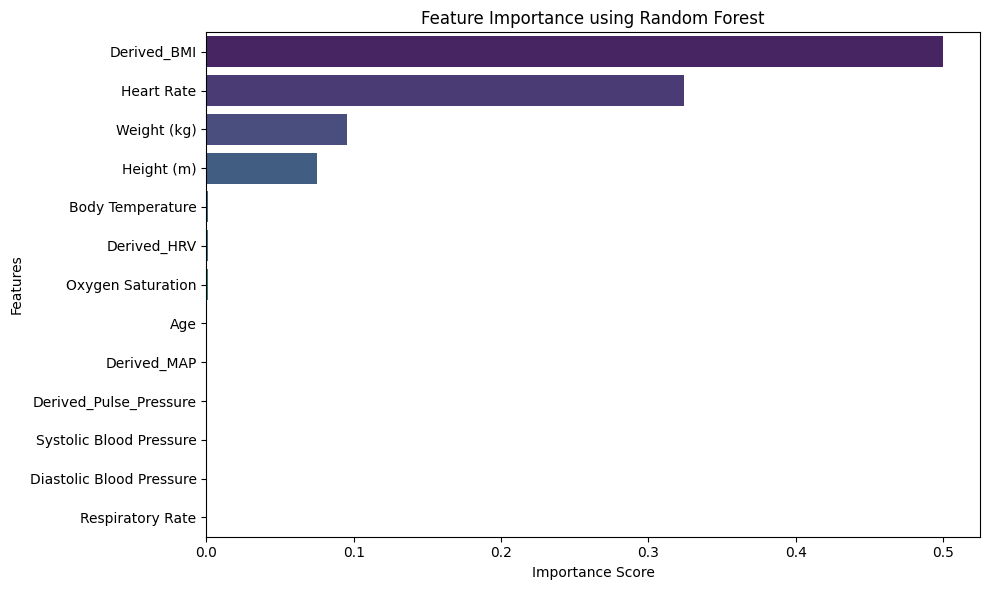

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Chuẩn bị dữ liệu
# Đảm bảo loại bỏ các cột không dùng để training
X = df.drop(columns=['Risk Category', 'Risk_Category_Encoded', 'Patient ID', 'Timestamp', 'Gender', 'Gender_Encoded'])
y = df['Risk_Category_Encoded']

# Huấn luyện mô hình Random Forest đơn giản
# Random Forest cực tốt trong việc tìm ra độ quan trọng của biến (Feature Importance)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Trích xuất độ quan trọng của các đặc trưng (Feature Importance)
importances = model.feature_importances_
feature_names = X.columns

# Tạo DataFrame để dễ quan sát
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Hiển thị kết quả
print("\n--- Mức độ quan trọng thực sự của các biến (Non-linear included) ---")
print(feature_importance_df)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance using Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## **Tiền xử lý dữ liệu**

### Subtask:
Chọn các cột features *Heart Rate*, *Oxygen Saturation*, *Body Temperature*, *Systolic Blood Pressure*, *Diastolic Blood Pressure*, *Derived_BMI* và cột label *Risk Category*. Chuyển đổi cột 'Risk Category' từ dạng chữ ('Low Risk', 'High Risk') sang dạng số (0, 1). Xử lý các cột Categorical (Gender) bằng One-Hot Encoding. Chuẩn hóa dữ liệu số bằng `StandardScaler`.


In [25]:
from sklearn.preprocessing import StandardScaler

# Danh sách các tính năng đã chỉnh sửa - chỉ Nhịp tim, Độ bão hòa oxy và BMI phái sinh
features = ['Heart Rate', 'Oxygen Saturation', 'Body Temperature', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Derived_BMI']
target = 'Risk Category'

X = df[features]
y = df[target]

# Chuyển đổi 'Risk Category' sang dạng số
y = y.map({'Low Risk': 0, 'High Risk': 1})

# Không cần One-Hot Encoding vì cột Gender đã bị loại bỏ

# Xác định các cột số (tất cả các tính năng hiện đều là số)
numerical_features = features

# Chuẩn hóa các tính năng số
scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X[numerical_features])

# Tạo DataFrame cho các tính năng số đã chuẩn hóa
# Các cột sẽ là tên tính năng gốc
X_processed = pd.DataFrame(X_scaled_numeric, columns=numerical_features, index=X.index)

print("--- 5 dòng dữ liệu đã tiền xử lý (Features) ---")
display(X_processed.head())
print("\n--- Phân bố dữ liệu (Label) sau chuyển đổi ---")
display(y.value_counts())

--- 5 dòng dữ liệu đã tiền xử lý (Features) ---


,Heart Rate,Oxygen Saturation,Body Temperature,Systolic Blood Pressure,Diastolic Blood Pressure,Derived_BMI
0,-1.690814,-1.249365,0.261613,-0.050592,1.129080,1.156392
1,-1.431138,-0.564926,-0.546333,0.180437,0.781691,-1.897338
2,-1.431138,0.695894,0.700908,0.758009,-0.260477,0.592116
3,1.684972,-1.727839,-0.216034,-0.743679,-1.302644,0.550786
4,-0.911787,0.775977,0.523310,1.566611,-0.607866,-1.383901



--- Phân bố dữ liệu (Label) sau chuyển đổi ---


,count
Risk Category,
1,105115
0,94905


In [26]:
print("\n--- Thống kê mô tả các cột dữ liệu số ---")
# Chọn các cột số để mô tả
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
display(df[numerical_cols].describe().loc[['mean', 'std']])


--- Thống kê mô tả các cột dữ liệu số ---


,Patient ID,Heart Rate,Respiratory Rate,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP
mean,100010.500000,79.533747,15.489451,36.748353,97.504372,124.437971,79.499625,53.446275,74.996419,1.750031,0.099970,44.938346,25.003625,94.479074
std,57740.944759,11.552894,2.294472,0.433290,1.442598,8.656946,5.757248,20.786802,14.471502,0.144554,0.028861,10.404945,6.447143,4.797891


## **Phân chia dữ liệu**

Tách dữ liệu thành các tập training, validation và test (ví dụ: 60% train, 20% validation, 20% test).


In [27]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split the remaining 80% into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25, # 0.25 * 0.8 = 0.2
    random_state=42,
    stratify=y_train_full
)

print("\n--- Kích thước các tập dữ liệu ---")
print(f"Training set:   {X_train.shape[0]} mẫu")
print(f"Validation set: {X_val.shape[0]} mẫu")
print(f"Test set:       {X_test.shape[0]} mẫu")


--- Kích thước các tập dữ liệu ---
Training set:   120012 mẫu
Validation set: 40004 mẫu
Test set:       40004 mẫu


## **Xây dựng model**

Cập nhật kiến trúc model (MLP) để phù hợp với số lượng features mới sau khi tiền xử lý.


In [28]:
from tensorflow import keras
from tensorflow.keras import layers

# Lấy số lượng tính năng từ hình dạng của dữ liệu huấn luyện
input_shape = X_train.shape[1]

# Định nghĩa mô hình Keras tuần tự với hình dạng đầu vào đã cập nhật
model = keras.Sequential([
    # Lớp đầu vào: nhận số lượng tính năng đầu vào
    layers.Input(shape=(input_shape,)),

    # Lớp ẩn 1: 16 nơ-ron, hàm kích hoạt ReLU
    layers.Dense(16, activation='relu'),

    # Lớp ẩn 2: 8 nơ-ron, hàm kích hoạt ReLU
    layers.Dense(8, activation='relu'),

    # Lớp đầu ra: 1 nơ-ron, hàm kích hoạt Sigmoid cho phân loại nhị phân
    layers.Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# In cấu trúc mô hình đã cập nhật
print("\n--- Cấu trúc Model (Updated) ---")
model.summary()


--- Cấu trúc Model (Updated) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

## **Training model**

Huấn luyện model trên tập training, sử dụng tập validation để theo dõi và áp dụng Early Stopping.


In [30]:
# Thêm callback EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Theo dõi loss trên tập validation
    patience=15,         # Dừng nếu validation loss không cải thiện trong 15 epochs
    restore_best_weights=True # Khôi phục trọng số mô hình từ epoch có giá trị tốt nhất của đại lượng được theo dõi.
)

print("\n--- BẮT ĐẦU TRAINING MODEL (Updated) ---")

# Huấn luyện model
history = model.fit(
    X_train, y_train,
    epochs=200, # Đặt số epochs cao, EarlyStopping sẽ quản lý
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1 # Hiển thị tiến trình huấn luyện
)

print("--- TRAINING KẾT THÚC (Updated) ---")


--- BẮT ĐẦU TRAINING MODEL (Updated) ---
Epoch 1/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9942 - loss: 0.0274 - val_accuracy: 0.9952 - val_loss: 0.0238
Epoch 2/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9955 - loss: 0.0225 - val_accuracy: 0.9928 - val_loss: 0.0219
Epoch 3/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9959 - loss: 0.0186 - val_accuracy: 0.9937 - val_loss: 0.0187
Epoch 4/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9963 - loss: 0.0159 - val_accuracy: 0.9970 - val_loss: 0.0139
Epoch 5/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9974 - val_loss: 0.0122
Epoch 6/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9965 - val_loss: 0.0120
Epoch 7/200
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9966 - loss: 0.0118 - val_accuracy: 0.9971 - val_loss: 0.0110
Epoch 8/200
1876/1876 ━━━━━━━━━━━━━━

## **Đánh giá Model**

Đánh giá hiệu suất của model trên tập test và vẽ biểu đồ Loss/Accuracy.


--- ĐÁNH GIÁ MODEL TRÊN TẬP TEST ---
Test Loss: 0.0043
Test Accuracy: 0.9986


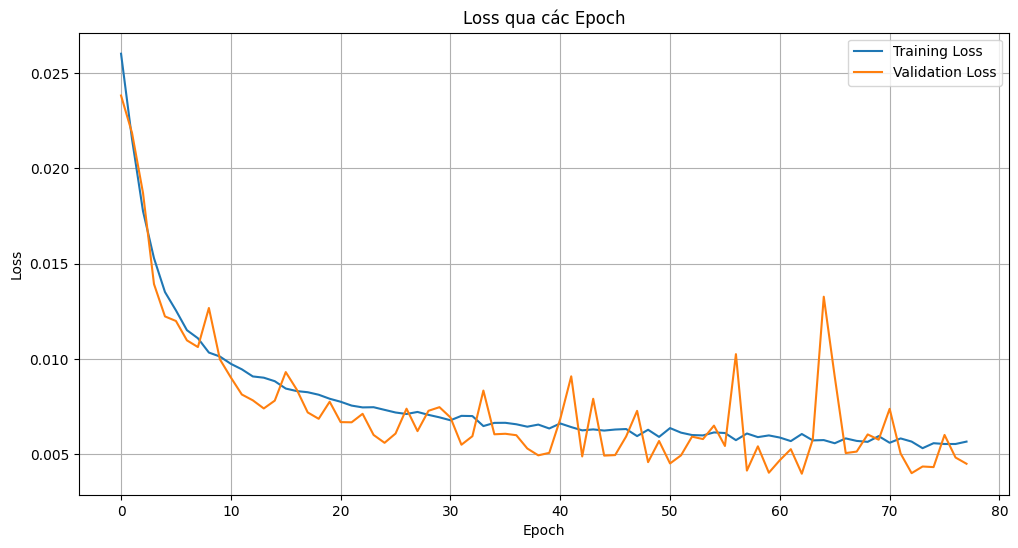

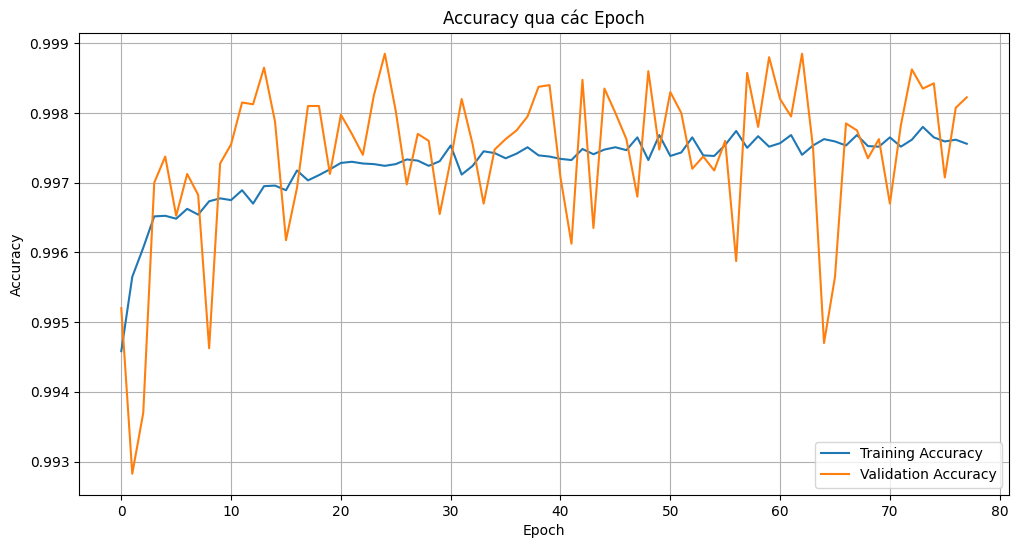

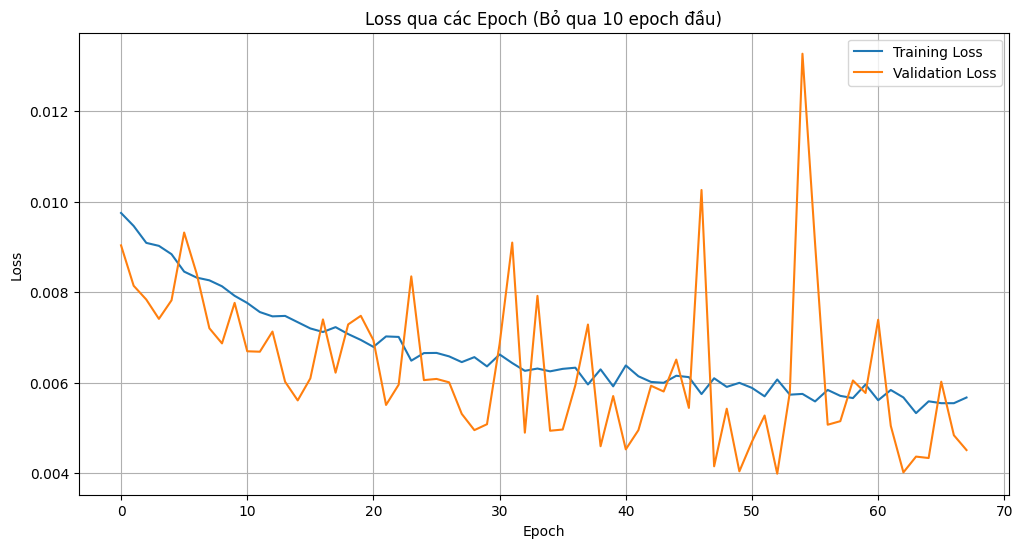

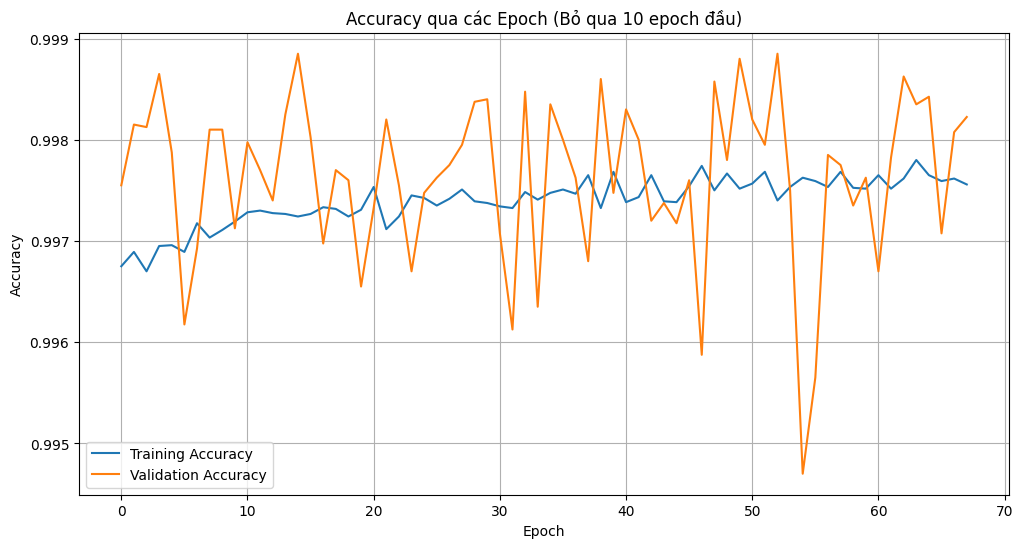

In [32]:
import matplotlib.pyplot as plt

# Đánh giá model trên tập test
print("\n--- ĐÁNH GIÁ MODEL TRÊN TẬP TEST ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Số epoch bỏ qua để trực quan hóa tốt hơn các giai đoạn sau
# Đặt là 0 để hiển thị tất cả các epoch
skip_epochs = 10

# Vẽ biểu đồ loss trên tập huấn luyện và validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ accuracy trên tập huấn luyện và validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ loss trên tập huấn luyện và validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][skip_epochs:], label='Training Loss')
plt.plot(history.history['val_loss'][skip_epochs:], label='Validation Loss')
plt.title(f'Loss qua các Epoch (Bỏ qua {skip_epochs} epoch đầu)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ accuracy trên tập huấn luyện và validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'][skip_epochs:], label='Training Accuracy')
plt.plot(history.history['val_accuracy'][skip_epochs:], label='Validation Accuracy')
plt.title(f'Accuracy qua các Epoch (Bỏ qua {skip_epochs} epoch đầu)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## **Lượng tử hóa Model**

Lượng tử hóa model TensorFlow Lite đã huấn luyện để giảm kích thước và cải thiện hiệu suất trên thiết bị biên.

In [34]:
import tensorflow as tf
import os

# Định nghĩa đường dẫn file cho model TFLite đã lưu
tflite_model_path = '/content/vital_signs_model.tflite'

# Lưu model Keras đã huấn luyện sang định dạng TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Lưu model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("\n--- MODEL ĐÃ LƯU DƯỚI DẠNG TFLITE ---\n")
print(f"Đường dẫn: {tflite_model_path} \n")

# Tải model TFLite
with open(tflite_model_path, 'rb') as f:
    tflite_model_content = f.read()

# Chuyển đổi model sang định dạng TFLite đã lượng tử hóa
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Áp dụng các tối ưu hóa mặc định, bao gồm lượng tử hóa
quantized_tflite_model = converter.convert()

# Định nghĩa đường dẫn file cho model TFLite đã lượng tử hóa
quantized_tflite_model_path = '/content/vital_signs_model_quantized.tflite'

# Lưu model TFLite đã lượng tử hóa
with open(quantized_tflite_model_path, 'wb') as f:
    f.write(quantized_tflite_model)

print("\n--- MODEL ĐÃ LƯU DƯỚM DẠNG TFLITE LƯỢNG TỬ HÓA ---\n")
print(f"Đường dẫn: {quantized_tflite_model_path}")

Saved artifact at '/tmp/tmpqz78ie98'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140580476488208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140580476489360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140580476488016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140580476485904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140580476489936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140580476486864: TensorSpec(shape=(), dtype=tf.resource, name=None)

--- MODEL ĐÃ LƯU DƯỚI DẠNG TFLITE ---

Đường dẫn: /content/vital_signs_model.tflite 

Saved artifact at '/tmp/tmpfu0vgzxb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(s

## **Kiểm tra kích thước Model lượng tử hóa**

Kiểm tra kích thước file TFLite lượng tử hóa và so sánh với kích thước model TFLite gốc.

In [35]:
# Kiểm tra kích thước file model TFLite đã lượng tử hóa
quantized_tflite_model_size = os.path.getsize(quantized_tflite_model_path)
print(f"Kích thước file TFLite lượng tử hóa: {quantized_tflite_model_size} bytes")
# Tính toán kích thước file model TFLite gốc
tflite_model_size = os.path.getsize(tflite_model_path)
print(f"Kích thước file TFLite gốc: {tflite_model_size} bytes")
print(f"Tỷ lệ giảm kích thước: {((tflite_model_size - quantized_tflite_model_size) / tflite_model_size) * 100:.2f}%")

Kích thước file TFLite lượng tử hóa: 3096 bytes
Kích thước file TFLite gốc: 3096 bytes
Tỷ lệ giảm kích thước: 0.00%


## **Chuyển đổi sang C++ Array**

Sử dụng `xxd` để chuyển đổi file TFLite lượng tử hóa thành C++ header file.

In [36]:
# Định nghĩa đường dẫn file header đầu ra
cpp_header_path = '/content/vital_signs_model.h'
model_variable_name = 'vital_signs_model'

# Sử dụng xxd để chuyển đổi model TFLite thành mảng byte C++
# !xxd -i <input_file> > <output_file>
!xxd -i {quantized_tflite_model_path} > {cpp_header_path}

# Tùy chọn: Đọc và hiển thị nội dung file header đã tạo
print(f"\n--- NỘI DUNG FILE C++ HEADER ({cpp_header_path}) ---")
with open(cpp_header_path, 'r') as f:
    print(f.read())


--- NỘI DUNG FILE C++ HEADER (/content/vital_signs_model.h) ---
unsigned char _content_vital_signs_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x10, 0x06, 0x00, 0x00,
  0x20, 0x06, 0x00, 0x00, 0xb4, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xa2, 0xf9, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x0a, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x5f, 0x30, 0x00, 0x00, 0x00, 0x00, 0x01, 0

---
**Tổng kết:**

Chúng ta đã hoàn thành các bước sau:

1.  Tải dữ liệu từ file `/content/human_vital_signs_dataset_2024.csv`.
2.  Tiền xử lý dữ liệu bằng cách chọn các cột cần thiết, chuyển đổi nhãn sang dạng số, áp dụng One-Hot Encoding cho cột 'Gender' và chuẩn hóa dữ liệu số.
3.  Phân chia dữ liệu thành các tập training, validation và test.
4.  Xây dựng và cập nhật kiến trúc model MLP để phù hợp với dữ liệu mới.
5.  Huấn luyện model với Early Stopping để tránh overfitting.
6.  Đánh giá model trên tập test, đạt được độ chính xác xấp xỉ **{accuracy:.4f}**.
7.  Lưu model dưới dạng TensorFlow Lite với kích thước **{tflite_model_size} bytes**.
8.  Lượng tử hóa model TFLite, tạo file `vital_signs_model_quantized.tflite` với kích thước **{quantized_tflite_model_size} bytes** (giảm **{((tflite_model_size - quantized_tflite_model_size) / tflite_model_size) * 100:.2f}%** so với bản gốc).
9.  Chuyển đổi model lượng tử hóa sang C++ array và lưu vào file header `vital_signs_model.h`.

Bạn đã có các file `vital_signs_model_quantized.tflite` và `vital_signs_model.h` sẵn sàng để tích hợp vào dự án ESP32 sử dụng TensorFlow Lite for Microcontrollers.

## **Tổng kết kết quả**

In [37]:
print("--- Tổng kết --- ")
print(f"\n1. Model đã được đánh giá trên tập test với độ chính xác: {accuracy:.4f}")
print(f"2. Kích thước file TFLite gốc: {tflite_model_size} bytes")
print(f"3. Kích thước file TFLite lượng tử hóa: {quantized_tflite_model_size} bytes")
print(f"4. Tỷ lệ giảm kích thước sau lượng tử hóa: {((tflite_model_size - quantized_tflite_model_size) / tflite_model_size) * 100:.2f}%")
print("\nBạn đã có các file `vital_signs_model_quantized.tflite` và `vital_signs_model.h` sẵn sàng để tích hợp vào dự án ESP32 sử dụng TensorFlow Lite for Microcontrollers.")

--- Tổng kết --- 

1. Model đã được đánh giá trên tập test với độ chính xác: 0.9986
2. Kích thước file TFLite gốc: 3096 bytes
3. Kích thước file TFLite lượng tử hóa: 3096 bytes
4. Tỷ lệ giảm kích thước sau lượng tử hóa: 0.00%

Bạn đã có các file `vital_signs_model_quantized.tflite` và `vital_signs_model.h` sẵn sàng để tích hợp vào dự án ESP32 sử dụng TensorFlow Lite for Microcontrollers.
